# Stanford CME 241 (Winter 2024) - Assignment 7

**Due: Mar 4 @ 11:59pm Pacific Time on Gradescope (after the exam).**

Assignment instructions:
- **Solve all 3 questions.**
- Empty code blocks are for your use. Feel free to create more under each section as needed.

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):* 

https://github.com/neelsnarayan/cme241/blob/master/neel_mehdi_assignments/assignment7/Neel_Mehdi_Assignment7.ipynb

*Group members (replace below names with people in your group):* 
- Neel Narayan
- Mehdi Zhioua

## Imports

In [1]:
%load_ext autoreload
%autoreload 2


from rl.chapter10.random_walk_mrp import RandomWalkMRP
from rl.markov_process import FiniteMarkovRewardProcess, TransitionStep
from typing import (Callable, Dict, Generic, Iterator, Iterable, List,
                    Mapping, Optional, Sequence, Tuple, TypeVar, overload)
from rl.distribution import Categorical
from itertools import product
import matplotlib.pyplot as plt
from rl.markov_process import State, MarkovProcess, NonTerminal, Terminal

from rl.function_approx import Gradient, FunctionApprox, DNNSpec, AdamGradient, DNNApprox, LinearFunctionApprox
from rl.approximate_dynamic_programming import extended_vf

import numpy as np


from typing import Sequence, Tuple, Mapping
from rl.markov_decision_process import NonTerminal, MarkovDecisionProcess
from rl.chapter2.simple_inventory_mrp import SimpleInventoryMRPFinite
from rl.chapter2.simple_inventory_mrp import InventoryState
from rl.chapter10.prediction_utils import (
    mc_finite_equal_wts_correctness,
    mc_finite_learning_rate_correctness,
    td_finite_learning_rate_correctness,
    td_lambda_finite_learning_rate_correctness,
    compare_td_and_mc
)

from rl.chapter2.simple_inventory_mrp import InventoryState
from rl.function_approx import Tabular
from rl.approximate_dynamic_programming import ValueFunctionApprox
from rl.distribution import Choose
from rl.iterate import last
from rl.monte_carlo import mc_prediction
from itertools import islice
from pprint import pprint

import rl.iterate as iterate
import rl.td as td
import itertools
from pprint import pprint
from rl.chapter10.prediction_utils import fmrp_episodes_stream
from rl.chapter10.prediction_utils import unit_experiences_from_episodes
from rl.function_approx import learning_rate_schedule


from rl.markov_decision_process import TransitionStep
from rl.distribution import Categorical, Choose
from rl.function_approx import LinearFunctionApprox
from rl.policy import DeterministicPolicy, FiniteDeterministicPolicy
from rl.dynamic_programming import value_iteration_result, V
from rl.chapter11.control_utils import get_vf_and_policy_from_qvf
from rl.td import least_squares_policy_iteration
from numpy.polynomial.laguerre import lagval
import itertools
import rl.iterate as iterate
import numpy as np
from rl.markov_decision_process import FiniteMarkovDecisionProcess

## Question 1
In the following question, we explore the connection between TD and MC
algorithms.

1.  Implement the TD($\lambda$) Prediction algorithm from scratch in
    Python code. First do it for the Tabular case, then do it for the
    case of Function Approximation.

2.  Prove that the MC Error can be written as the sum of discounted TD
    errors, i.e.,
    $$G_t - V(S_t) = \sum_{u=t}^{T-1} \gamma^{u-t} \cdot (R_{u+1} + \gamma \cdot V(S_{u+1}) - V(S_u))$$
    The goal here is for you to practice formal proof-writing of these
    types of simple yet important identities. So aim to work this out
    from scratch rather than treating this as a special case of a more
    general result proved in class or in the textbook.

3.  Test your above implementation of TD($\lambda$) Prediction algorithm
    by comparing the Value Function of an MRP you have previously
    developed (or worked with) as obtained by Policy Evaluation (DP)
    algorithm, as obtained by MC, as obtained by TD, and as obtained by
    your TD($\lambda$) implementation. Plot graphs of convergence for
    different values of $\lambda$.

4.  Extend `RandomWalkMRP` (in
    [rl/chapter10/random_walk_mrp.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter10/random_walk_mrp.py))
    to `RandomWalkMRP2D` which is a random walk in 2-D with states
    $\{i, j) | 0 \leq i \leq B_1, 0 \leq j \leq B_2\}$ with terminal
    states as $(0, j)$ and $(B_1, j)$ for all $j$, $(i, 0)$ and
    $(i, B_2)$ for all $i$, and with reward of 0 for all $(0, j)$ and
    for all $(i, 0)$, reward of 1 for all $(B_1, j)$ and for all
    $(i, B_2)$, and with discrete probabilities of 4 movements - UP,
    DOWN, LEFT, RIGHT from any non-terminal state. Analyze the
    convergence of MC and TD on this `RandomWalkMRP2D` much like how we
    analyzed it for `RandomWalkMRP`, along with plots of similar graphs.

### 1. Implementation of TD($\lambda$)

#### 1.1 Tabular

In [312]:
def reset_fintie_E(mrp,S0):
    """
    Setup eligibility traces for finite mrp
    """
    E = {}
    for nt in mrp.non_terminal_states:
        E[nt.state] = 0
    E[S0] = 1
    return E

def reset_finite_V(mrp):
    """ 
    Initializes value function
    """
    V = {}
    for nt in mrp.non_terminal_states:
        V[nt.state] = 0
    return V

def update_finite_E(mrp,s,E,gamma,lambd):
    """ 
    Implements the update equation E_t(s)=γ·λ·E_(t−1)(s)+I(St=s) 
    """
    for s_ in mrp.non_terminal_states:
        E[s_.state] = gamma*lambd*E[s_.state]
    E[s] = E[s]+1
    return E

def update_finite_V(mrp,s_prime,s,r,E,V,alpha,gamma):
    """ 
    Implements the update step V(s)←V(s)+α·(Rt+1 +γ·V(St+1)−V(St))·Et(s)
    s_prime and s : state attribute of S_{t+1} and S_t
    r = R_{t+1}
    """
    V_prime = 0 #if next state is terminal
    if s_prime in V:
        V_prime = V[s_prime] #if next state is non terminal

    for s_ in mrp.non_terminal_states:
        V[s_.state] = V[s_.state] + alpha*( r + gamma*V_prime - V[s] ) * E[s_.state]

    
    return V

def td_lambda_finite_tabular(mrp, gamma, alpha, lambd, start_mrp,max_iter = 100,epsiode_length_tolerance=1e-6):
    """
    start_mrp : distribution from which we sample the start state
    """
    #setup value function and eligibility traces
    all_V = []

    V = reset_finite_V(mrp)
    E = None #will be set using start state in the loop

    #get traces for mrp
    simulations = mrp.reward_traces(start_state_distribution=start_mrp)

    for i,sim in enumerate(simulations):
        if i>=max_iter:
            break
        #Get transitions for one episode
        gamma_k = 1 #for epsiode length control

        for j,x in enumerate(sim):

            gamma_k = gamma_k*gamma

            if gamma_k <= epsiode_length_tolerance:
                break

            s = x.state.state #get next state as a tuple
            s_prime = x.next_state.state #get next state as a tuple
            r = x.reward
            if j == 0:
                E = reset_fintie_E(mrp,s)
            else:
                #Update eligibility traces
                E = update_finite_E(mrp,s,E,gamma,lambd)
            
            #update V
            V = update_finite_V(mrp, s_prime, s, r, E,  V, alpha, gamma)
            all_V.append(V.copy())

    return V, all_V

#### 1.2 Function approx

In [328]:
def td_lambda_approx(mrp, gamma, lambd, start_mrp, approx_0,max_iter=100):
    simulations = mrp.reward_traces(start_state_distribution=start_mrp)
    all_approx = []
    for i,sim in enumerate(simulations):
        if i>=max_iter:
            break

        el_tr = Gradient(approx_0).zero()

        for x in sim:
            s = x.state  #get next state as a tuple
            r = x.reward
            X,Y= s,r+gamma*extended_vf(approx_0, x.next_state)
            
            el_tr = el_tr*(gamma*lambd) + approx_0.objective_gradient(xy_vals_seq = [(X,Y)],
                                                                    obj_deriv_out_fun= lambda x1, y1: np.ones(len(x1)))
            all_approx.append(approx_0)
            approx_0 = approx_0.update_with_gradient(el_tr * (approx_0(X) - Y))
    return approx_0, all_approx

#### 2.

We can expand the right hand side of the sum :
$$
\sum_{u=t}^{T-1} \gamma^{u-t} \cdot (R_{u+1} + \gamma \cdot V(S_{u+1}) - V(S_u))  =\left( \sum_{u=t}^{T-1} \gamma^{u-t} R_{u+1} \right) + \left( \sum_{u=t}^{T-1} \gamma^{u+1-t}V(S_{u+1}) - \gamma^{u-t}V(S_{u}) \right)
$$
The rightmost sum is telescopic : 
$$
\left( \sum_{u=t}^{T-1} \gamma^{u+1-t}V(S_{u+1}) - \gamma^{u-t}V(S_{u}) \right) = \gamma^{T-t} V(S_T) - V(S_t)
$$
Therefore : 

\begin{align*}
\sum_{u=t}^{T-1} \gamma^{u-t} \cdot (R_{u+1} + \gamma \cdot V(S_{u+1}) - V(S_u))  &= \sum_{u=t}^{T-1} \gamma^{u-t} R_{u+1} + \gamma^{T-t} V(S_T) - V(S_t)\\
&= G_t - V(S_t)
\end{align*}
Which is what we wanted to show 

#### 3. Testing our implementation on Simple Inventory

##### MRP Setup

In [283]:

#Instanciate a SimpleInventory MRP
capacity: int = 2
poisson_lambda: float = 1.0
holding_cost: float = 1.0
stockout_cost: float = 10.0

si_mrp: SimpleInventoryMRPFinite = SimpleInventoryMRPFinite(
    capacity=capacity,
    poisson_lambda=poisson_lambda,
    holding_cost=holding_cost,
    stockout_cost=stockout_cost
)

#Object we use to sample over start distributions
initial_inventory = Categorical(
    {x: 1/len(si_mrp.non_terminal_states) for x in  si_mrp.non_terminal_states  }
)

#Value function
si_mrp.display_value_function(gamma=0.9)

V_star = si_mrp.get_value_function_vec(gamma=0.9) #get the value function as a numpy array

{NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -39.329,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -38.329,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -38.971,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -37.329,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -37.971,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -43.596}


##### MC (cf. book p.315)

In [334]:
traces: Iterable[Iterable[TransitionStep[InventoryState]]] = \
        si_mrp.reward_traces(Choose(si_mrp.non_terminal_states))
it: Iterator[ValueFunctionApprox[InventoryState]] = mc_prediction(
    traces=traces,
    approx_0=Tabular(),
    γ=0.9,
    episode_length_tolerance=1e-3
)
num_traces = 10
last_func: ValueFunctionApprox[InventoryState] = last(islice(it, num_traces))


    
pprint({s: round(last_func.evaluate([s])[0], 3) for s in si_mrp.non_terminal_states})

{NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -40.618,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -38.384,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -38.716,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -37.786,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -38.079,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -44.275}


In [335]:
#We store here the erros || V - V_star||_2 for MC iterations

all_V = []
errors_mc = []
for i,v in enumerate(it):
    if i>=1000:
        break
    V_mc = np.array([v(x) for x in si_mrp.non_terminal_states])
    all_V.append(V_mc)
    errors_mc.append(np.linalg.norm(V_mc-V_star))

##### Using TD (cf. book p.320)

In [265]:
episode_length: int = 100
initial_learning_rate: float = 0.03
half_life: float = 1000.0
exponent: float = 0.5
gamma: float = 0.9
episodes: Iterable[Iterable[TransitionStep[InventoryState]]] = \
    fmrp_episodes_stream(si_mrp)
td_experiences: Iterable[TransitionStep[InventoryState]] = \
    unit_experiences_from_episodes(
episodes,
        episode_length
    )
learning_rate_func: Callable[[int], float] = learning_rate_schedule(
    initial_learning_rate=initial_learning_rate,
    half_life=half_life,
    exponent=exponent
)
td_vfs: Iterator[ValueFunctionApprox[InventoryState]] = td.td_prediction(
    transitions=td_experiences,
    approx_0=Tabular(count_to_weight_func=learning_rate_func),
     γ=gamma
)
num_episodes = 10000
final_td_vf: ValueFunctionApprox[InventoryState] = \
    iterate.last(itertools.islice(td_vfs, episode_length * num_episodes))
pprint({s: round(final_td_vf(s), 3) for s in si_mrp.non_terminal_states})

{NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -39.069,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -37.398,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -43.6,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -37.974,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -38.101,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -38.967}


In [270]:
#We store here the erros || V - V_star||_2 for TD iterations

all_V_td = []
errors_td = []
for i,v in enumerate(td_vfs):
    if i>=100000:
        break
    V_td = np.array([v(x) for x in si_mrp.non_terminal_states])
    all_V.append(V_td)
    errors_td.append(np.linalg.norm(V_td-V_star))

##### Using TD($\lambda$) tabular

In [346]:
V_td_lambda_01 ,all_V_td_lambda_01 = td_lambda_finite_tabular(si_mrp, gamma=0.9, 
                                                        alpha=0.3, lambd=0.1, start_mrp=initial_inventory, 
                                                        max_iter=1000) 

V_td_lambda_03 ,all_V_td_lambda_03 = td_lambda_finite_tabular(si_mrp, gamma=0.9, 
                                                        alpha=0.3, lambd=0.3, start_mrp=initial_inventory, 
                                                        max_iter=1000) 

V_td_lambda_05 ,all_V_td_lambda_05 = td_lambda_finite_tabular(si_mrp, gamma=0.9, 
                                                        alpha=0.3, lambd=0.5, start_mrp=initial_inventory, 
                                                        max_iter=1000) 

V_td_lambda_09 ,all_V_td_lambda_09 = td_lambda_finite_tabular(si_mrp, gamma=0.9, 
                                                        alpha=0.3, lambd=0.9, start_mrp=initial_inventory, 
                                                        max_iter=1000) 

In [347]:
#V_star found by TD lambda
all_V_td_lambda_09[-1]

{InventoryState(on_hand=0, on_order=0): -41.65405686854124,
 InventoryState(on_hand=0, on_order=1): -37.00055884500754,
 InventoryState(on_hand=0, on_order=2): -34.82908621686721,
 InventoryState(on_hand=1, on_order=0): -38.695600046173155,
 InventoryState(on_hand=1, on_order=1): -40.64206187228168,
 InventoryState(on_hand=2, on_order=0): -38.29599845817826}

In [348]:
#We store here the erros || V - V_star||_2 for TD(lambda) iterations

all_errs = []

for all_Vs in [all_V_td_lambda_01,all_V_td_lambda_03, all_V_td_lambda_05, all_V_td_lambda_09 ]:

    errors_td_lambda = []
    for i,v in enumerate(all_Vs):
        if i>=5000:
            break
        V_td_lambda = np.array([v[x.state] for x in si_mrp.non_terminal_states])
        errors_td_lambda.append(np.linalg.norm(V_td_lambda-V_star))

    all_errs.append(errors_td_lambda)

##### Comparing convergence

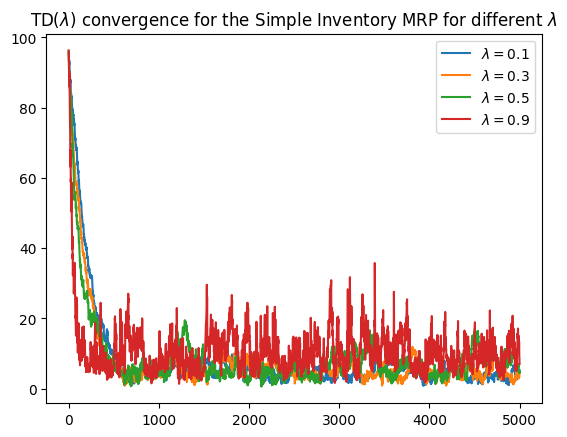

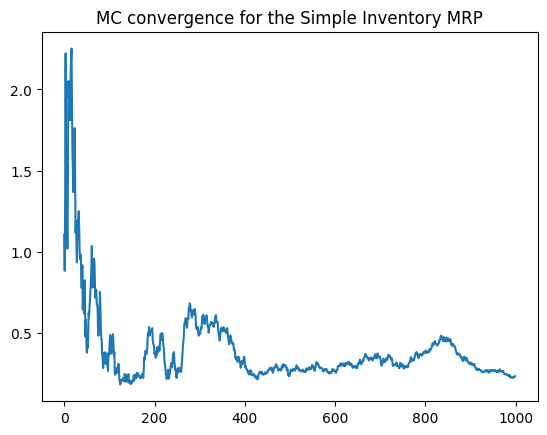

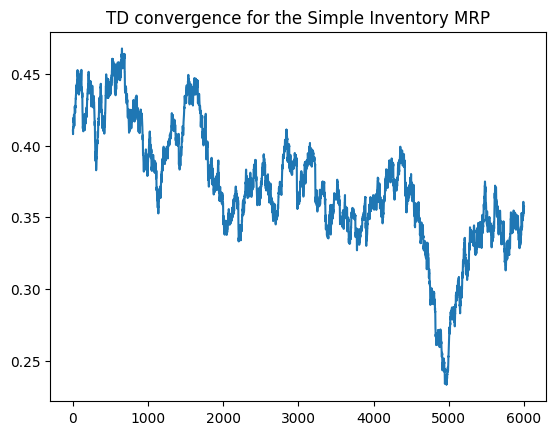

In [357]:
plt.title(r"TD($\lambda$) convergence for the Simple Inventory MRP for different $\lambda$")
plt.plot(all_errs[0],label=r"$\lambda = 0.1$")
plt.plot(all_errs[1],label=r"$\lambda = 0.3$")
plt.plot(all_errs[2],label=r"$\lambda = 0.5$")
plt.plot(all_errs[3],label=r"$\lambda = 0.9$")
plt.legend()
plt.show()
plt.title(r"MC convergence for the Simple Inventory MRP")
plt.plot(errors_mc)
plt.show()
plt.title(r"TD convergence for the Simple Inventory MRP")
plt.plot(errors_td[:6000])

We notice here that TD seems to very quickly the correct value function (even after a very small number of episodes) but it doesn't really learn further when increasing the number of iterations and the L2 norm seems very choppy. For MC, as noted in the book, the learning trajectory is also choppy but we observe that the V learned is consistent. We visually notice that the TD lambda curve is somewhat a tradeoff between TD and TD lambda. 

#### 4.

In [42]:
class RandomWalkMRP2D(FiniteMarkovRewardProcess[int]):
    B1: int
    B2: int 
    p_up: float
    p_right: float
    p_left: float
    p_down: float 

    def __init__(
        self,
        B1: int,
        B2: int,
        p_up: float,
        p_right: float,
        p_down: float,
        p_left: float
    ):
        self.B1 = B1
        self.B2 = B2
        self.p_up = p_up
        self.p_right = p_right
        self.p_down = p_down
        self.p_left = p_left
        super().__init__(self.get_transition_map())

    def get_transition_map(self) -> \
            Mapping[Tuple[int,int], Categorical[Tuple[int, float]]]:
        d: Dict[Tuple[int, int], Categorical[Tuple[Tuple[int, int] , float]]] = {
            (i,j) : Categorical({
                ((i,j+1),0. if j < self.B2 - 1 else 1. ) : self.p_up,    #up 
                ((i,j-1),0.) : self.p_down,                              #down
                ((i+1,j),0. if i < self.B1 - 1 else 1.) : self.p_right,  #right
                ((i-1,j),0.) : self.p_left,                              #left 
            }) for i,j in product(range(1,self.B1), range(1,self.B2))
        }
        return d

##### Instance of MRP

In [366]:
B1 = 10
B2 = 9

start_state = Categorical({
    NonTerminal((i,j)):1/(B1-1)*(B2-1) for i,j in product(range(1,B1), range(1,B2)) 
    })   #equal probability to inner grid cells

walk = RandomWalkMRP2D(B1=B1, B2 = B2, p_up = 0.25, p_right=0.25, p_down=0.25, p_left=0.25)

##### Useful function for visualizing V from approx function

In [428]:
def approx_2D_to_np(apx,walk_):
    """
    We use it to visualize the optimal function found as a 2D numpy array
    """
    V_star_ = np.zeros((walk_.B1+1,walk_.B2+1))
    for k,st in enumerate(walk_.non_terminal_states):
        i,j = st.state
        V_star_[i,j] = apx(st)

    return V_star_

In [386]:
V_star = np.zeros((B1+1,B2+1)) #represent it in the form of a 2x2 array
V_opt = walk.get_value_function_vec(gamma=0.9)
for k,st in enumerate(walk.non_terminal_states):
    i,j = st.state
    V_star[i,j] = V_opt[k]

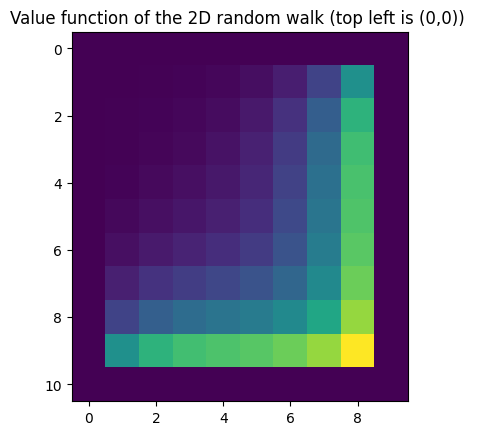

In [424]:
plt.title("Value function of the 2D random walk (top left is (0,0)) ")
plt.imshow(V_star) #in the image the top left corner is (0,0)

#### TD

In [426]:

episodes= fmrp_episodes_stream(walk)

td_experiences =  unit_experiences_from_episodes(episodes, episode_length)

learning_rate_func: Callable[[int], float] = learning_rate_schedule(
    initial_learning_rate=initial_learning_rate,
    half_life=half_life,
    exponent=exponent
)

td_vfs = td.td_prediction(
    transitions=td_experiences,
    approx_0=Tabular(count_to_weight_func=learning_rate_func),
    γ=gamma
)

num_episodes = 100
final_td_vf = iterate.last(itertools.islice(td_vfs, episode_length * num_episodes))

In [430]:
V_td = approx_2D_to_np(final_td_vf,walk)

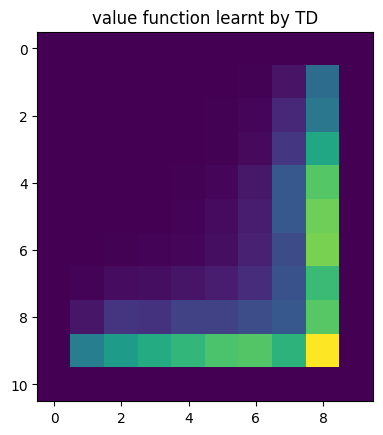

In [434]:
plt.title("value function learnt by TD")
plt.imshow(V_td)

In [437]:
errors_td = []
for i,v in enumerate(td_vfs):
    if i>=100000:
        break
    V_td = approx_2D_to_np(v,walk)
    errors_td.append(np.linalg.norm(V_td-V_star))

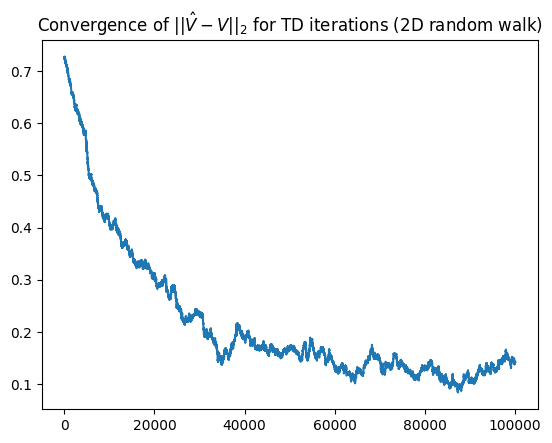

In [445]:
plt.title(r"Convergence of $||\hat{V}-V||_2$ for TD iterations (2D random walk)")
plt.plot(errors_td)

#### MC

In [401]:
def approx_2D_to_np(apx,walk_):
    """
    We use it to visualize the optimal function found as a 2D numpy array
    """
    V_star_ = np.zeros((walk_.B1+1,walk_.B2+1))
    for k,st in enumerate(walk_.non_terminal_states):
        i,j = st.state
        V_star_[i,j] = apx(st)

    return V_star_

In [408]:
traces= walk.reward_traces(Choose(walk.non_terminal_states))

it: Iterator[ValueFunctionApprox[InventoryState]] = mc_prediction(
    traces=traces,
    approx_0=Tabular(),
    γ=0.9,
    episode_length_tolerance=1e-5
)

num_traces = 100
last_func = last(islice(it, num_traces))

V_mc = approx_2D_to_np(last_func,walk)

In [418]:
errors_mc = []
for i,v in enumerate(it):
    if i>=10000:
        break
    V_mc = approx_2D_to_np(v,walk)
    all_V.append(V_mc)
    errors_mc.append(np.linalg.norm(V_mc-V_star))

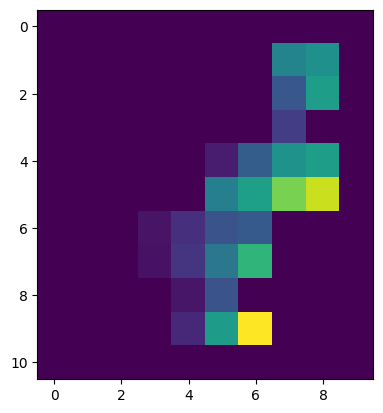

In [407]:
plt.imshow(V_mc)

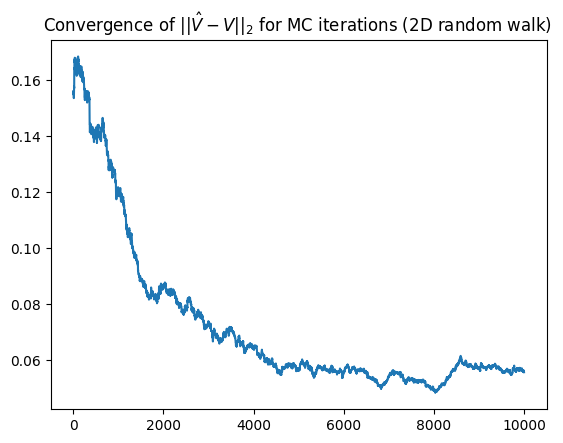

In [444]:
plt.title(r"Convergence of $||\hat{V}-V||_2$ for MC iterations (2D random walk) ")
plt.plot(errors_mc)

## Question 2
In this question, we will explore three different algorithms for control
based on MC or TD. Please complete 2 of the following 3 implementations.
For each algorithm, we expect you to test your implementation against
the Optimal Value Function/Optimal Policy obtained by DP on
`SimpleInventoryMDPCap` in
[rl/chapter3/simple_inventory_mdp_cap.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter3/simple_inventory_mdp_cap.py).
Then, generalize to MC Control with Function approximation and test your
implementation against the Optimal Value Function/Optimal Policy
obtained by ADP on `AssetAllocDiscrete` in
[rl/chapter7/asset_alloc_discrete.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter7/asset_alloc_discrete.py).

1.  Implement Tabular Monte-Carlo Control algorithm in Python with GLIE
    implemented as $\epsilon = \frac 1 k$ for episode number $k$ and
    initial state of each episode sampled uniformly from the state
    space.

2.  Implement Tabular SARSA algorithm in Python with GLIE and a
    parameterized trajectory of decreasing step sizes.

3.  Implement Tabular Q-Learning algorithm in Python with infinite
    exploration of all (state, action) pairs and with a parameterized
    trajectory of decreasing step sizes.

In [8]:
from dataclasses import dataclass
from typing import Tuple, Dict, Mapping
from rl.markov_decision_process import FiniteMarkovDecisionProcess
from rl.policy import FiniteDeterministicPolicy
from rl.markov_process import TransitionStep, NonTerminal, Terminal
from rl.markov_process import FiniteMarkovProcess, FiniteMarkovRewardProcess
from rl.distribution import Categorical
from scipy.stats import poisson
import numpy as np
import random
from collections import defaultdict

@dataclass(frozen=True)
class InventoryState:
    on_hand: int
    on_order: int

    def inventory_position(self) -> int:
        return self.on_hand + self.on_order

InvOrderMapping = Mapping[
    InventoryState,
    Mapping[int, Categorical[Tuple[InventoryState, float]]]
]

class SimpleInventoryMDPCap(FiniteMarkovDecisionProcess[InventoryState, int]):

    def __init__(
        self,
        capacity: int,
        poisson_lambda: float,
        holding_cost: float,
        stockout_cost: float
    ):
        self.capacity: int = capacity
        self.poisson_lambda: float = poisson_lambda
        self.holding_cost: float = holding_cost
        self.stockout_cost: float = stockout_cost

        self.poisson_distr = poisson(poisson_lambda)
        super().__init__(self.get_action_transition_reward_map())

    def get_action_transition_reward_map(self) -> InvOrderMapping:
        d: Dict[InventoryState, Dict[int, Categorical[Tuple[InventoryState,
                                                            float]]]] = {}

        for alpha in range(self.capacity + 1):
            for beta in range(self.capacity + 1 - alpha):
                state: InventoryState = InventoryState(alpha, beta)
                ip: int = state.inventory_position()
                base_reward: float = - self.holding_cost * alpha
                d1: Dict[int, Categorical[Tuple[InventoryState, float]]] = {}

                for order in range(self.capacity - ip + 1):
                    sr_probs_dict: Dict[Tuple[InventoryState, float], float] =\
                        {(InventoryState(ip - i, order), base_reward):
                         self.poisson_distr.pmf(i) for i in range(ip)}

                    probability: float = 1 - self.poisson_distr.cdf(ip - 1)
                    reward: float = base_reward - self.stockout_cost * \
                        (self.poisson_lambda - ip * 
                        (1 - self.poisson_distr.pmf(ip) / probability))
                    sr_probs_dict[(InventoryState(0, order), reward)] = \
                        probability
                    d1[order] = Categorical(sr_probs_dict)

                d[state] = d1
        return d

def mc(mdp: FiniteMarkovDecisionProcess, episodes: int, gamma: float) -> Dict:
    q_values = defaultdict(lambda: defaultdict(float))
    rewards = defaultdict(lambda: defaultdict(list))
    policy = {state: random.choice(list(mdp.actions(state))) for state in mdp.non_terminal_states}

    for episode in range(1, episodes + 1):
        # GLIE
        epsilon = 1 / episode
        sarsa_tuples = []
        # as per the assignment spec, the initial state is sampled uniformly from the state space
        state = random.choice(list(mdp.non_terminal_states))

        # here we generate an episode, bounding the limit on the loop to guarantee that we get an episode
        for _ in range(1000):
            # using GLIE
            if random.uniform(0, 1) > epsilon:
                action = policy[state]
            else:
                action = random.choice(list(mdp.actions(state)))
            # get next state and reward from that state
            next_state, reward = mdp.step(state, action).sample()
            # append to list
            sarsa_tuples.append((state, action, reward))
            # we can break before 1000 iterations because at this point, the episode has
            # ended since we've reached a terminal state
            if isinstance(state, Terminal):
                break
            state = next_state

        next_reward = 0
        for state, action, reward in sarsa_tuples:
            # r = $\gamma$ * next_reward + r to add current award and then discount future reward
            next_reward = gamma * next_reward + reward
            rewards[state][action].append(next_reward)
            # q update from slides
            q_values[state][action] = max(rewards[state][action])
            policy[state] = max(q_values[state])

    return policy

In [6]:
user_capacity = 2
user_poisson_lambda = 1.0
user_holding_cost = 1.0
user_stockout_cost = 10.0

user_gamma = 0.9

si_mdp = c(
    capacity=user_capacity,
    poisson_lambda=user_poisson_lambda,
    holding_cost=user_holding_cost,
    stockout_cost=user_stockout_cost
)

In [7]:
policy = mc(si_mdp, 1, user_gamma)
policy

{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): 2,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): 1,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): 0,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): 1,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): 0,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): 0}

In [4]:
from dataclasses import dataclass
from typing import Tuple, Dict, Mapping
from rl.markov_decision_process import FiniteMarkovDecisionProcess
from rl.policy import FiniteDeterministicPolicy
from rl.markov_process import FiniteMarkovProcess, FiniteMarkovRewardProcess
from rl.distribution import Categorical
from scipy.stats import poisson


@dataclass(frozen=True)
class InventoryState:
    on_hand: int
    on_order: int

    def inventory_position(self) -> int:
        return self.on_hand + self.on_order


InvOrderMapping = Mapping[
    InventoryState,
    Mapping[int, Categorical[Tuple[InventoryState, float]]]
]


class SimpleInventoryMDPCap(FiniteMarkovDecisionProcess[InventoryState, int]):

    def __init__(
        self,
        capacity: int,
        poisson_lambda: float,
        holding_cost: float,
        stockout_cost: float
    ):
        self.capacity: int = capacity
        self.poisson_lambda: float = poisson_lambda
        self.holding_cost: float = holding_cost
        self.stockout_cost: float = stockout_cost

        self.poisson_distr = poisson(poisson_lambda)
        super().__init__(self.get_action_transition_reward_map())

    def get_action_transition_reward_map(self) -> InvOrderMapping:
        d: Dict[InventoryState, Dict[int, Categorical[Tuple[InventoryState,
                                                            float]]]] = {}

        for alpha in range(self.capacity + 1):
            for beta in range(self.capacity + 1 - alpha):
                state: InventoryState = InventoryState(alpha, beta)
                ip: int = state.inventory_position()
                base_reward: float = - self.holding_cost * alpha
                d1: Dict[int, Categorical[Tuple[InventoryState, float]]] = {}

                for order in range(self.capacity - ip + 1):
                    sr_probs_dict: Dict[Tuple[InventoryState, float], float] =\
                        {(InventoryState(ip - i, order), base_reward):
                         self.poisson_distr.pmf(i) for i in range(ip)}

                    probability: float = 1 - self.poisson_distr.cdf(ip - 1)
                    reward: float = base_reward - self.stockout_cost * \
                        (self.poisson_lambda - ip * 
                        (1 - self.poisson_distr.pmf(ip) / probability))
                    sr_probs_dict[(InventoryState(0, order), reward)] = \
                        probability
                    d1[order] = Categorical(sr_probs_dict)

                d[state] = d1
        return d


if __name__ == '__main__':
    from pprint import pprint

    user_capacity = 2
    user_poisson_lambda = 1.0
    user_holding_cost = 1.0
    user_stockout_cost = 10.0

    user_gamma = 0.9

    si_mdp: FiniteMarkovDecisionProcess[InventoryState, int] =\
        SimpleInventoryMDPCap(
            capacity=user_capacity,
            poisson_lambda=user_poisson_lambda,
            holding_cost=user_holding_cost,
            stockout_cost=user_stockout_cost
        )

    print("MDP Transition Map")
    print("------------------")
    print(si_mdp)

    fdp: FiniteDeterministicPolicy[InventoryState, int] = \
        FiniteDeterministicPolicy(
            {InventoryState(alpha, beta): user_capacity - (alpha + beta)
             for alpha in range(user_capacity + 1)
             for beta in range(user_capacity + 1 - alpha)}
    )

    print("Deterministic Policy Map")
    print("------------------------")
    print(fdp)

    implied_mrp: FiniteMarkovRewardProcess[InventoryState] =\
        si_mdp.apply_finite_policy(fdp)
    print("Implied MP Transition Map")
    print("--------------")
    print(FiniteMarkovProcess(
        {s.state: Categorical({s1.state: p for s1, p in v.table().items()})
         for s, v in implied_mrp.transition_map.items()}
    ))

    print("Implied MRP Transition Reward Map")
    print("---------------------")
    print(implied_mrp)

    print("Implied MP Stationary Distribution")
    print("-----------------------")
    implied_mrp.display_stationary_distribution()
    print()

    print("Implied MRP Reward Function")
    print("---------------")
    implied_mrp.display_reward_function()
    print()

    print("Implied MRP Value Function")
    print("--------------")
    implied_mrp.display_value_function(gamma=user_gamma)
    print()

    from rl.dynamic_programming import evaluate_mrp_result
    from rl.dynamic_programming import policy_iteration_result
    from rl.dynamic_programming import value_iteration_result

    print("Implied MRP Policy Evaluation Value Function")
    print("--------------")
    pprint(evaluate_mrp_result(implied_mrp, gamma=user_gamma))
    print()

    print("MDP Policy Iteration Optimal Value Function and Optimal Policy")
    print("--------------")
    opt_vf_pi, opt_policy_pi = policy_iteration_result(
        si_mdp,
        gamma=user_gamma
    )
    pprint(opt_vf_pi)
    print(opt_policy_pi)
    print()

    print("MDP Value Iteration Optimal Value Function and Optimal Policy")
    print("--------------")
    opt_vf_vi, opt_policy_vi = value_iteration_result(si_mdp, gamma=user_gamma)
    pprint(opt_vf_vi)
    print(opt_policy_vi)
    print()

MDP Transition Map
------------------
From State InventoryState(on_hand=0, on_order=0):
  With Action 0:
    To [State InventoryState(on_hand=0, on_order=0) and Reward -10.000] with Probability 1.000
  With Action 1:
    To [State InventoryState(on_hand=0, on_order=1) and Reward -10.000] with Probability 1.000
  With Action 2:
    To [State InventoryState(on_hand=0, on_order=2) and Reward -10.000] with Probability 1.000
From State InventoryState(on_hand=0, on_order=1):
  With Action 0:
    To [State InventoryState(on_hand=1, on_order=0) and Reward -0.000] with Probability 0.368
    To [State InventoryState(on_hand=0, on_order=0) and Reward -5.820] with Probability 0.632
  With Action 1:
    To [State InventoryState(on_hand=1, on_order=1) and Reward -0.000] with Probability 0.368
    To [State InventoryState(on_hand=0, on_order=1) and Reward -5.820] with Probability 0.632
From State InventoryState(on_hand=0, on_order=2):
  With Action 0:
    To [State InventoryState(on_hand=2, on_order=

The States match (210100), as desired

## Question 3
Finally, we will explore reinforcment learning algorithms and apply them
to the problem of Amercian options pricing. Implement the following two
algorithms and apply them to the problem of American Options Pricing, as
covered in class. Test by comparing the pricing of American Calls and
Puts against the Binomial Tree implmeentation in
[rl/chapter8/optimal_exercise_bin_tree.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter8/optimal_exercise_bin_tree.py).

1.  LSPI

2.  Deep Q-Learning

### 1. LSPI

We make use here of the least_squares_policy_iteration as implemented in the td file. The least_squares_policy_iteration function takes as input :
- `transitions: Iterable[TransitionStep[S, A]]`. This is the training data that we give as input to the LSPI algorithm. It is a finite set of transitions (state, action , next_state, reward). Here we will model the state as (t,S) and action as 0/1 depending on wether we exercise the option or no. reward is the payoff of the option if exercised and 0 otherwise. We generate this data in our AmericanOptionLSPI class as the `lspi_transitions` method of our `AmericanOptionLSPI` class
- `actions: Callable[[NonTerminal[S]], Iterable[A]]`. Here we have only two choices : exercise the function or no
- `feature_functions: Sequence[Callable[[Tuple[NonTerminal[S], A]], float]]`. For the feature functions, we follow Li, Szepesvari and Schuurmans recommendation : 

    - $\phi_0\left(S_t\right)=1$
    - $\phi_1\left(S_t\right)=e^{-\frac{M_t}{2}}$
    - $\phi_2\left(S_t\right)=e^{-\frac{M_t}{2}} \cdot\left(1-M_t\right)$
    - $\phi_3\left(S_t\right)=e^{-\frac{M_t}{2}} \cdot\left(1-2 M_t+M_t^2 / 2\right)$
    - $\phi_0^{(t)}(t)=\sin \left(\frac{\pi(T-t)}{2 T}\right)$
    - $\phi_1^{(t)}(t)=\log (T-t)$
    - $\phi_2^{(t)}(t)=\left(\frac{t}{T}\right)^2$
where $M_t=\frac{S_t}{K}$ ( $S_t$ is the current underlying price and $K$ is the American Option strike), $t$ is the current time, and $T$ is the expiration time (i.e., $0 \leq t<T$ ).
- `initial_target_policy: DeterministicPolicy[S, A]`. we will choose as starting policy to never exercise the option

In [2]:
def price_process(S0,T,sigma):
    """
    Underlying price dynamics used to generate the tansition steps
    Can be replaced by any arbitrary price dynamic
    """
    S = S0
    states = [(S,0,T)]
    for t in range(1,T+1):
        S,_,_ = states[-1]
        S = S+sigma*np.random.randn()
        states.append((S,t,T))
    
    return states 

states = price_process(100,200,0.2)

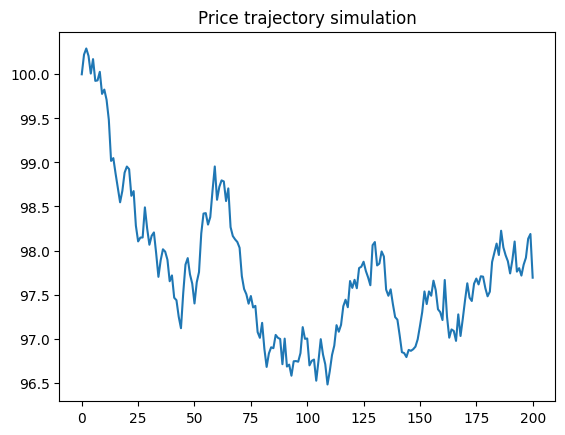

In [3]:
plt.title("Price trajectory simulation")
plt.plot( [x[0] for x in states])

In [142]:
class AmericanOptionLSPI():
    """
    - We represent each state as (t,T,S_t) (timestamp, maturity, spot price)
    - the price will shift up or down by 1 randomly
    """

    def __init__(self, T=20, p=0.5, S0 = 100, K = 100, sigma = 0.2,  type = "Call"):


        self.T = T #Expiry
        self.p = p  #Probability of price increasing by 1
        self.S0 = 100 #Initial spot price
        self.K = K #Strike price
        self.type = type #Either "Put" or "Call"
        self.sigma = sigma 

    def payoff(self,x):
        if self.type=="Call":
            return x-self.K if x >=self.K else 0
        if self.type=="Put":
            return self.K - x if self.K >= x else 0


    def simulate_trajectory(self):
        """
        We use this to simulate trajectories of prices
        """
        return price_process(self.S0,self.T,self.sigma)

    
    def lspi_transitions(self) -> Iterator[TransitionStep[Tuple[float, int, int], int]]:
        """
        We take a transition from a simulated trajectory of prices
        Tuple[float, int, int] represents the state (S_t, t, T)
        """
        while True:
            trajectory = self.simulate_trajectory()
            (St,t,T) = Choose(trajectory[:-1]).sample() #sample a spot price from a trajectory
            next_state = trajectory[t+1] #next state
            
            a = Choose([0,1]).sample()
            if a:
                reward = self.payoff(St)
                next_state = Terminal(next_state)
            else:
                reward = 0
                if t+1<T:
                    next_state = NonTerminal(next_state)
                else:
                    next_state = Terminal(next_state)

            transition = TransitionStep(
                state = NonTerminal((St,t,T)),
                action=a,
                next_state=next_state,
                reward = reward
            )

            yield transition

    def lspi_features(self):
        """
        Generate the Li, Szepesvari and Schuurmans features
        x[0] is a state, which is (St, t, T)
        """
        #We use here phi(s,a) = [0,...,0,g(s)] is a = 1, i.e when exercise option (last entry of w should therefore be learned as 1)
        # and phi(s,a) = [phi_0,...,phi_3,phi_0^t,...,phi_3^t ,0] when a=0, i.e we learn phi(s) as written in p. 403 of the book
        return [
            lambda x : 1 if x[1]==0 else 0,
            lambda x : np.exp(- 0.5 * x[0].state[0]/self.K) if x[1] == 0 else 0,
            lambda x : np.exp(- 0.5 * x[0].state[0]/self.K) * ( 1 - x[0].state[0]/self.K) if x[1] == 0 else 0, 
            lambda x : np.exp(- 0.5 * x[0].state[0]/self.K) * ( 1 - 2 * x[0].state[0]/self.K + 0.5*(x[0].state[0]/self.K)**2) if x[1] == 0 else 0,
            lambda x : np.sin( 0.5 * np.pi * ( x[0].state[2] - x[0].state[1] ) / x[0].state[2] ) if x[1] == 0 else 0,
            lambda x : np.log( x[0].state[2] - x[0].state[1] ) if x[1] == 0 else 0,
            lambda x : (x[0].state[1] / x[0].state[2])**2 if x[1] == 0 else 0,
            lambda x : self.payoff(x[0].state[0]) if x[1] == 1 else 0
        ]

    def lspi_actions(self):
        def exercise_decision(s : NonTerminal[Tuple[float, int, int]]):
            return [0,1]
        return exercise_decision

    def lspi_vf(self):

        transitions = itertools.islice(
            self.lspi_transitions(),
            20000
        )

        qvf_iter = least_squares_policy_iteration(
                transitions=transitions,
                actions=self.lspi_actions(),
                feature_functions=self.lspi_features(),
                initial_target_policy=DeterministicPolicy(
                    lambda s: 0 #never exercise the action
                ),
                γ=1.0,
                ε=1e-5
            )

        return qvf_iter


In [145]:
american_opt = AmericanOptionLSPI(type = "Call")            
it = american_opt.lspi_vf()

from tqdm import tqdm

for i,x_call in tqdm(enumerate(it)):
    if i>=500:
        break

500it [06:51,  1.22it/s]


In [146]:
def exercise_boundary(x_,T):

    """
    plot optimal exercise price boundary
    """
    
    price_range = np.arange(90,100,0.1)

    boundary = []

    for t in range(T):

        no_ex = [ x_((NonTerminal((price,t,T)),0))  for price in price_range]
        ex =  [ x_((NonTerminal((price,t,T)),1))  for  price in price_range]

        #find price where to value functions intersect
        price_boundary = price_range[ min(range(len(no_ex)), key=lambda i: abs(no_ex[i] - ex[i]))  ]

        boundary.append(price_boundary)

    return boundary

bound_call = exercise_boundary(x_call,150)

Text(0.5, 0, 'time')

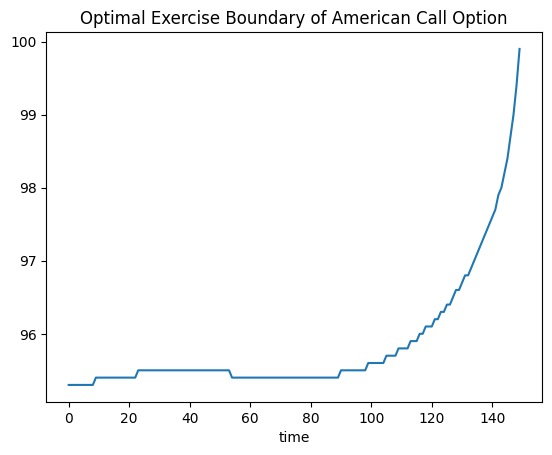

In [147]:
plt.title("Optimal Exercise Boundary of American Call Option")
plt.plot(bound_call)
plt.xlabel("time")

In [148]:
american_opt = AmericanOptionLSPI(type="Put")            
it = american_opt.lspi_vf()

from tqdm import tqdm

for i,x_put in tqdm(enumerate(it)):
    if i>=500:
        break

500it [06:44,  1.23it/s]


In [149]:
bound_put = exercise_boundary(x_put,150)

Text(0.5, 0, 'time')

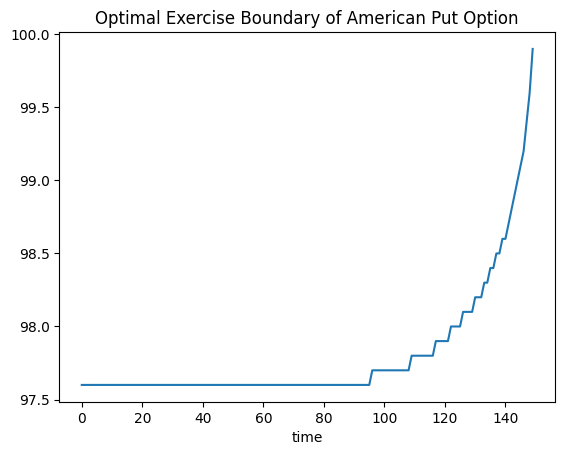

In [150]:
plt.title("Optimal Exercise Boundary of American Put Option")
plt.plot(bound_put)
plt.xlabel("time")

We notice that we find similar shapes of the optimal price execution boundary as in the binomial tree example, less the choppy segments (because we model our process in continuous state)

### 2. Deep Q-Learning

We recall here the setup of the Deep Q Learning algorithm, as explained in p.405: 
$$
\hat{Q}(s, a ; \boldsymbol{w})=\left\{\begin{array}{ll}
f(s ; \boldsymbol{w}) & \text { if } a=c \\
g(s) & \text { if } a=e
\end{array} \text { for all } s \in \mathcal{N}\right.
$$
where $f(s ; \boldsymbol{w})$ is the deep neural network function approximation.
The Q-Learning update for each atomic experience $\left(s_i, s_i^{\prime}\right)$ is:
$$
\Delta \boldsymbol{w}=\alpha \cdot\left(\gamma \cdot \hat{Q}\left(s_i^{\prime}, \pi\left(s_i^{\prime}\right) ; \boldsymbol{w}\right)-f\left(s_i ; \boldsymbol{w}\right)\right) \cdot \nabla_{\boldsymbol{w}} f\left(s_i ; \boldsymbol{w}\right)
$$

When $s_i^{\prime}$ is a non-terminal state, the update is:
$$
\Delta \boldsymbol{w}=\alpha \cdot\left(\gamma \cdot \max \left(g\left(s_i^{\prime}\right), f\left(s_i^{\prime} ; \boldsymbol{w}\right)\right)-f\left(s_i ; \boldsymbol{w}\right)\right) \cdot \nabla_{\boldsymbol{w}} f\left(s_i ; \boldsymbol{w}\right)
$$

When $s_i^{\prime}$ is a terminal state, the update is:
$$
\Delta \boldsymbol{w}=\alpha \cdot\left(\gamma \cdot g\left(s_i^{\prime}\right)-f\left(s_i ; \boldsymbol{w}\right)\right) \cdot \nabla_{\boldsymbol{w}} f\left(s_i ; \boldsymbol{w}\right)
$$

We adapt here the code from p.365 to implement Deep Q Learning in this context

In [ ]:
class AmericanOption_Deep_Q_Learning():

    def __init__(self, T=20, p=0.5, S0 = 100, K = 100, sigma = 0.2,  type = "Call"):
        self.T = T #Expiry
        self.p = p  #Probability of price increasing by 1
        self.S0 = 100 #Initial spot price
        self.K = K #Strike price
        self.type = type #Either "Put" or "Call"
        self.sigma = sigma 

    def payoff(self,x):
        if self.type=="Call":
            return x-self.K if x >=self.K else 0
        if self.type=="Put":
            return self.K - x if self.K >= x else 0

    def Nueral_Network(self):
        """

        Initializes Q value function approximator as a neural network with 
        features being the Li, Szepesvari and Schuurmans recommendation

        """"

        ffs= [lambda x : 1,  
              lambda x : np.exp(- 0.5 * x[0].state[0]/self.K),
              lambda x : np.exp(- 0.5 * x[0].state[0]/self.K) * ( 1 - x[0].state[0]/self.K), 
              lambda x : np.exp(- 0.5 * x[0].state[0]/self.K) * ( 1 - 2 * x[0].state[0]/self.K + 0.5*(x[0].state[0]/self.K)**2),
              lambda x : np.sin( 0.5 * np.pi * ( x[0].state[2] - x[0].state[1] ) / x[0].state[2] ),
              lambda x : np.log( x[0].state[2] - x[0].state[1]) 
              lambda x : (x[0].state[1] / x[0].state[2])**2 ]
            
        def relu(arg: np.ndarray) -> np.ndarray:
            return np.vectorize(lambda x: x if x > 0. else 0.)(arg)
        def relu_deriv(res: np.ndarray) -> np.ndarray:
            return np.vectorize(lambda x: 1. if x > 0. else 0.)(res)
        def identity(arg: np.ndarray) -> np.ndarray:
            return arg
        def identity_deriv(res: np.ndarray) -> np.ndarray:
            return np.ones_like(res)

        dnn = DNNSpec(
        neurons=[10],
        bias=True,
        hidden_activation=relu,
        hidden_activation_deriv=relu_deriv,
        output_activation=identity,
        output_activation_deriv=identity_deriv
        )
        adam_gradient = AdamGradient(learning_rate=0.1, decay1=0.9, decay2=0.999)
        
        return DNNApprox.create(feature_functions=ffs,dnn_spec=dnn,adam_gradient=adam_gradient)


    def deep_Q_learning(
        self,
        mdp, #we need to write a method to instanciate the mdp for this problem 
        policy_from_q,
        states,
        approx_0,
        gamma: float,
        max_episode_length: int

    ):
        q =  approx_0 
        yield q

        while True:

            state = states.sample()
            steps  = 0

            while isinstance(state, NonTerminal) and steps < max_episode_length:
                policy = policy_from_q(q, mdp)
                action = policy.act(state).sample()
                next_state, reward = mdp.step(state, action).sample()
                #next update as per p.405 in the book
                next_return = max(q((next_state,0)), self.payoff(state.state[0])) if isinstance(next_state, NonTerminal) else self.payoff(state.state[0])
                q = q.update([((state, action), reward + gamma * next_return)])
                yield q
                steps += 1
                state = next_state


## did not find the time to complete this part of the problem